Trabalho realizado por: Mohamed Haddadi nº107193

## Modelo de difusão

Um modelo de difusão (ou de remoção de ruído) não é tão complexo quanto outros modelos generativos, como [GANs ou VAEs](https://yang-song.net/blog/2021/score/). Todos convertem ruído de uma distribuição simples em uma amostra de dados. Neste caso, uma rede neural aprende gradualmente a denoizar (remover ruído) dados a partir de ruído puro.

Existem várias perspectivas nos modelos de difusão, este trabalho se concentrará na perspectiva de tempo discreto (modelo de variável latente) tendo por base o trabalho [DDPM](https://arxiv.org/abs/2006.11239) e o código [Diffusion](https://github.com/hojonathanho/diffusion?tab=readme-ov-file) por Jonathan Ho.

A configuração consiste basicamente em 2 processos:
* Um processo de difusão direta fixo (ou predefinido) $q$ da nossa escolha, que adiciona gradualmente ruído Gaussiano a uma imagem, até obter ruído puro.
* Um processo de remoção de ruído reverso aprendido $p_\theta$, onde uma rede neural é treinada para gradualmente remover o ruído de uma imagem a partir de ruído puro, até obter uma imagem real.


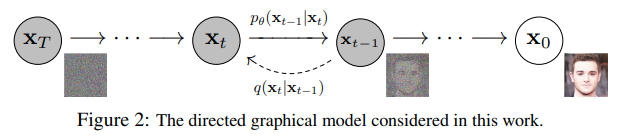



Ambos os processos direto e reverso indexados por $t$ ocorrem durante um número finito de passos de tempo $T$ (no DDPM usam $T=1000$, portanto vamos usar o mesmo). Começamos com $t=0$, onde se amostra uma imagem real $\mathbf{x}_0$ da distribuição de dados, e o processo direto mostra algum ruído de uma distribuição Gaussiana em cada passo de tempo $t$, que é adicionado à imagem do passo anterior. Dado um $T$ suficientemente grande e um cronograma bem comportado para adicionar ruído em cada passo de tempo, terminamos com o que é chamado de [distribuição Gaussiana isotrópica](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic) em $t=T$ através de um processo gradual.

## A matemática por trás

Vamos escrever isso de forma mais formal, pois precisamos de uma função de perda tratável que nossa rede neural precisa otimizar.

Seja $q(\mathbf{x}_0)$ a distribuição de dados reais, digamos de "imagens reais". Podemos amostrar desta distribuição para obter uma imagem, $\mathbf{x}_0 \sim q(\mathbf{x}_0)$. Definimos o processo de difusão direta $q(\mathbf{x}_t | \mathbf{x}_{t-1})$ que adiciona ruído Gaussiano em cada passo de tempo $t$, de acordo com um cronograma de variância conhecido $0 < \beta_1 < \beta_2 < ... < \beta_T < 1$ como
$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}). 
$$

Como sabemos, distribuição Gaussiana é definida por dois parâmetros: uma média $\mu$ e uma variância $\sigma^2 \geq 0$. Basicamente, cada nova imagem (ligeiramente mais ruidosa) no passo de tempo $t$ é desenhada de uma **distribuição Gaussiana condicional** com $\mathbf{\mu}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1}$ e $\sigma^2_t = \beta_t$, que podemos fazer ao amostrar $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ e definir $\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}$. 

Os $\beta_t$ não são constantes em cada passo de tempo $t$ — de fato, define-se um **"cronograma de variância"**, que pode ser linear, quadrático, cosseno, etc.

Assim, começando com $\mathbf{x}_0$, terminamos com $\mathbf{x}_1,  ..., \mathbf{x}_t, ..., \mathbf{x}_T$, onde $\mathbf{x}_T$ é ruido Gaussiano puro se definirmos o cronograma adequadamente.

Agora, se conhecessemos a distribuição condicional $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$, então poderíamos executar o processo em reverso: amostrando algum ruído Gaussiano aleatório $\mathbf{x}_T$, e então ir "removendo o ruído" gradualmente para acabar com uma amostra da distribuição real $\mathbf{x}_0$.

No entanto, não conhecemos $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$. É intratável, pois requer conhecer a distribuição de todas as possíveis imagens para calcular esta probabilidade condicional. Portanto, vamos aproveitar uma rede neural para aproximar (aprender) esta distribuição de probabilidade condicional, que chamaremos de $p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)$, com $\theta$ sendo os parâmetros da rede neural, atualizados por descida de gradiente. 

Então, precisamos de uma rede neural para representar uma distribuição de probabilidade (condicional) do processo reverso. Se assumirmos que este processo reverso também é Gaussiano, então temos os dois parâmetros:
* uma média parametrizada por $\mu_\theta$;
* uma variância parametrizada por $\Sigma_\theta$;

então podemos parametrizar o processo como 
$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$
onde a média e a variância também são condicionadas ao nível de ruído $t$.


Portanto, a nossa rede neural precisa de aprender/representar a média e a variância. No entanto, os autores do DDPM decidiram manter a variância fixa e deixar a rede neural aprender (representar) apenas a média $\mu_\theta$ desta distribuição de probabilidade condicional. No artigo:

> Primeiro, definimos $\Sigma_\theta ( \mathbf{x}_t, t) = \sigma^2_t \mathbf{I}$ como constantes dependentes do tempo não treinadas. Experimentalmente, tanto $\sigma^2_t = \beta_t$ como $\sigma^2_t  = \tilde{\beta}_t$ (ver artigo) tiveram resultados semelhantes.


Assim, vamos assumir que a nossa rede neural só precisa de aprender/representar a média desta distribuição de probabilidade condicional.


## Definindo uma função objetivo 

Para derivar uma função objetivo para aprender a média do processo reverso, a combinação de $q$ e $p_\theta$ pode ser vista como um auto-encoder variacional (VAE) [(Kingma et al., 2013)](https://arxiv.org/abs/1312.6114). Portanto, o limite inferior variacional (ELBO) pode ser usado para minimizar a log-verossimilhança negativa em relação à amostra de dados verdadeira $\mathbf{x}_0$. Verifica-se que o ELBO para este processo é uma soma de perdas em cada passo de tempo $t$, $L = L_0 + L_1 + ... + L_T$. Por construção do processo direto $q$ e do processo reverso, cada termo (exceto $L_0$) da perda é na verdade a divergência KL entre 2 distribuições Gaussianas, que pode ser escrita explicitamente como uma perda L2 em relação às médias.

Uma consequência direta do processo direto construído $q$ (Sohl-Dickstein et al.) , é que podemos amostrar $\mathbf{x}_t$ em qualquer nível arbitrário de ruído condicionado em $\mathbf{x}_0$ (já que a soma de Gaussianas é também Gaussiana). 
Temos que 
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})$$

com $\alpha_t := 1 - \beta_t$ e $\bar{\alpha}_t := \Pi_{s=1}^{t} \alpha_s$.Isto significa que podemos amostrar ruído Gaussiano, escalá-lo adequadamente e adicioná-lo a $\mathbf{x}_0$ para obter $\mathbf{x}_t$ diretamente. 



Outra consequência é que podemos [reparametrizar a média para que a rede neural aprenda (preveja) o ruído adicionado (através de uma rede $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ para o nível de ruído $t$** nos termos de KL que constituem as perdas](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/). Isto significa que a nossa rede neural se torna um "preditor" de ruído, em vez de um "preditor" de média (direta). A média pode ser calculada da seguinte forma:

$$ \mathbf{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(  \mathbf{x}_t - \frac{\beta_t}{\sqrt{1- \bar{\alpha}_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \right)$$

A função objetivo final $L_t$ tem então a seguinte aparência (para um passo de tempo aleatório $t$ dado $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$):

$$ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \|^2 = \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)} \mathbf{\epsilon}, t) \|^2.$$

Aqui, $\mathbf{x}_0$ é a imagem inicial (real), e vemos o nível de ruído direto $t$ amostrado pelo processo de avanço fixo. $\mathbf{\epsilon}$ é o ruído puro amostrado no passo de tempo $t$, e $\mathbf{\epsilon}_\theta (\mathbf{x}_t, t)$ é a nossa rede neural. A rede neural é otimizada com uso de um simples erro quadrático médio (MSE) entre o ruído Gaussiano verdadeiro e o previsto.

O algoritmo de treino agora é o seguinte:

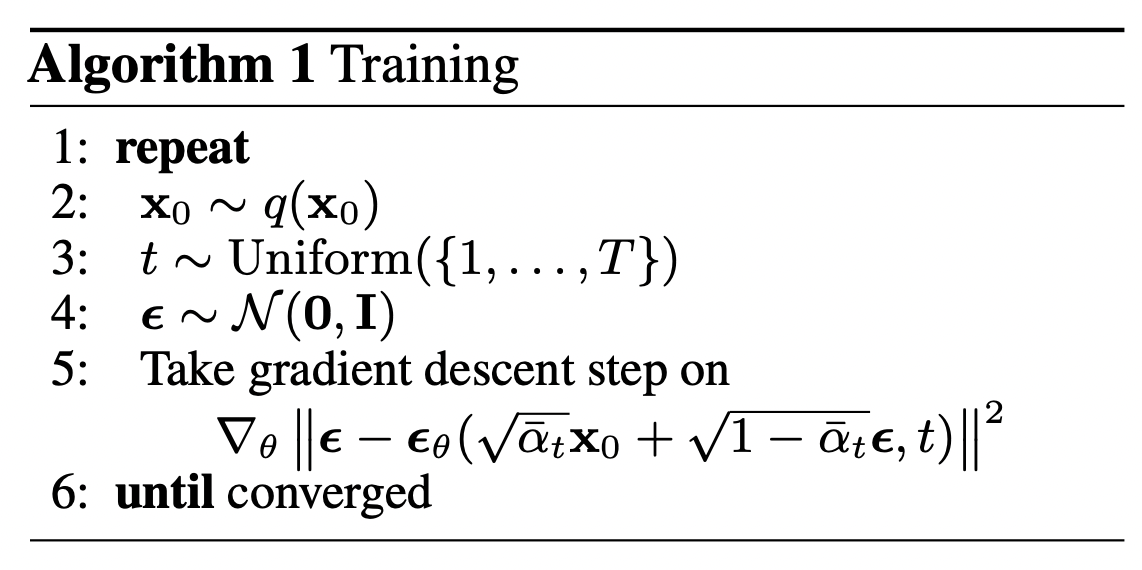



## A rede neural

A rede neural precisa receber uma imagem com ruído em um determinado passo de tempo e retornar o ruído previsto. O ruído previsto é um tensor que tem o mesmo tamanho/resolução que a imagem de entrada. Portanto, tecnicamente, a rede recebe e gera tensores de mesma forma.

O que é tipicamente usado aqui é basicamente um [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder).
Autoencoders têm uma camada chamada "gargalo" entre o codificador e o decodificador. O codificador primeiro codifica uma imagem em uma representação oculta menor chamada "gargalo", e o decodificador então decodifica essa representação oculta de volta em uma imagem real. Isso força a rede a manter apenas as informações mais importantes na camada de gargalo.

Os autores do DDPM optaram por um **U-Net**, introduzido por ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)).
Esta rede, como qualquer autoencoder, consiste em um gargalo no meio que garante que a rede aprenda apenas as informações mais importantes.
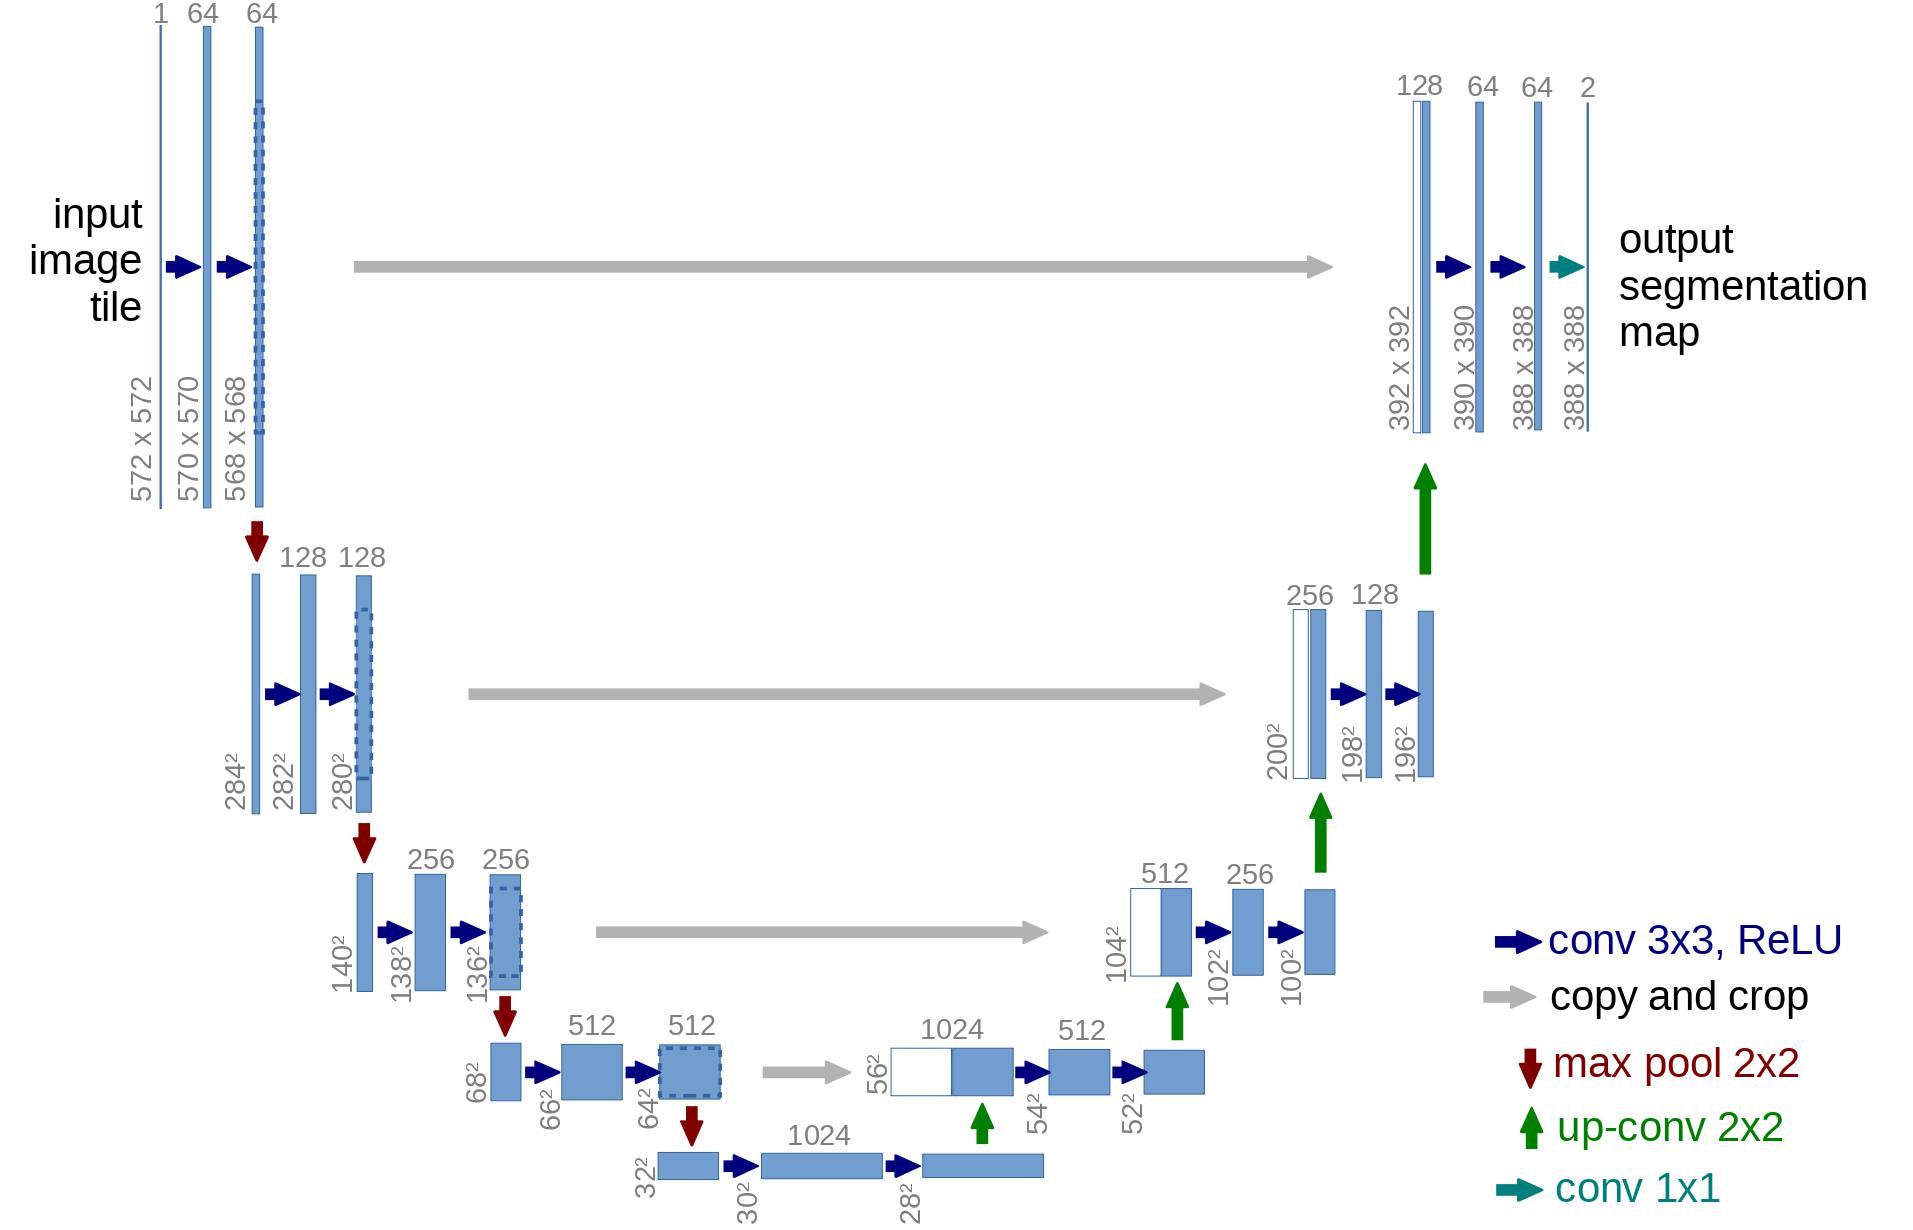


Podemos ver que um modelo U-Net primeiro reduz a resolução espacial da entrada, depois que é realizado faz o aumento da resolução.

Aqui vamos tentar implementamor esta rede.


## Setup 
Instalação de algumas bilbiotecas que vão ser usadas neste trabalho, parte-se do princípio que já possui a torch e torchvision, entre outras mais comun como numpy etc...

In [1]:
#!pip install -q -U einops datasets matplotlib tqdm plyer

In [2]:
#!pip install ffmpeg

In [3]:
#!pip install dataset

Na geração do gif, pode dar problema com a biblioteca pyarrow, recomenda-se a reeinstalação da mesma.

In [4]:
# se dar erro com pyarrow
#!pip uninstall pyarrow
#!pip install pyarrow

In [5]:
#!pip install plyer

Importamos as da bibliotécas que vão ser necessárias

In [6]:
import math
from inspect import isfunction
from functools import partial
from plyer import notification
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
import dataset
import torch
from torch import nn, einsum
import torch.nn.functional as F

In [7]:
""" 
Primeiro, definimos algumas funçoes e classes auxiliares que serão usadas na implementação da rede neural. Importante, definimos um módulo "Residual", 
que simplesmente adiciona a entrada a saida de uma funçao particular (em outras palavras, adiciona uma conexao residual a uma funçao particular).

Tambem definimos aliases para as operações de aumento e reduçao de resoluçao. 

"""


def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [8]:
""" 

Como os parametros da rede neural são compartilhados ao longo do nivel de ruido, os autores utilizam embeddings posicionais senosoidais para codificar t.
Isso faz com que a rede neural "saiba" em qual passo de nível de ruido ela está, para cada imagem em um lote.

O modulo "SinusoidalPositionEmbeddings" recebe um tensor de forma "(batch_size, 1)" como entrada (os niveis de ruido de varias imagens ruidosas em um lote) e 
transforma isso em um tensor de forma "(batch_size, dim)", com "dim" a dimensionalidade dos embeddings posicionais.
Isso é entao adicionado a cada bloco residual.


 """
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [9]:

""" 
Aqui definimos o bloco principal do modelo U-Net. Os autores do DDPM empregaram um bloco Wide ResNet, adicionamos tambem um bloco ConvNeXT, 
que parece ter grande sucesso no domínio da imagem. Pode-se escolher um ou outro na arquitetura final do U-Net.

 """


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)
    
""" 
Os autores do DDPM adicionaram entre os blocos convolucionais um modulo "Attention". O Attention é o bloco de construção da arquitetura Transformer (https://arxiv.org/abs/1706.03762).

 """
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [10]:
""" 
Os autores do DDPM intercalam as camadas do U-Net com normalização de grupo. 
A classe PreNorm, que serve para aplicar a normalização de grupo antes da camada de Attention.
 """
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### U-Net condicional

A rede recebe um lote de imagens ruidosas de forma "(batch_size, num_channels, height, width)" e um lote de níveis de ruido de forma "(batch_size, 1)" como entrada, e retorna um tensor de forma "(batch_size, num_channels, height, width)"

A rede é construída da seguinte forma:

* 1 - Uma camada convolucional é aplicada no lote de imagens ruidosas, e embeddings posicionais são calculados para os níveis de ruído

* 2 - Uma sequência de estágios de redução de resolução é aplicada. Cada estágio de redução de resolução consiste em 2 blocos ResNet/ConvNeXT + normalização de grupo + attention + conexão residual + uma operação de redução de resolução

* 3 - Mais a meio da rede, novamente são aplicados blocos ResNet ou ConvNeXT, intercalados com attention

* 4 - Uma sequência de estágios de aumento de resolução é aplicada. Cada estágio de aumento de resolução consiste em 2 blocos ResNet/ConvNeXT + normalização de grupo + attention + conexão residual + uma operação de aumento de resolução
* 5 - Um bloco ResNet/ConvNeXT seguido de uma camada convolucional é aplicado.


In [11]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Processo de difusão direta

O processo de difusão direta adiciona gradualmente ruído a uma imagem da distribuição real, em um número de passos de tempo $T$. Isso acontece de acordo com um cronograma de variância. Os autores originais do DDPM empregaram um cronograma linear:

> Definimos as variâncias do processo direto como constantes aumentando linearmente de $\beta_1 = 10^{−4}$ para $\beta_T = 0.02$.

Abaixo, definimos vários cronogramas para os $T$ passos de tempo.


In [12]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

## Primeiros passos do modelo

Primeiro, vamos usar o cronograma linear para $T=1000$ passos de tempo e definir as várias variáveis a partir de $\beta_t$ que precisaremos, como o produto cumulativo das variâncias $\bar{\alpha}_t$. Cada uma das variáveis abaixo são apenas tensores unidimensionais, armazenando valores de $t$ para $T$.


In [13]:
timesteps = 1000

# define-se o cronograma do beta
betas = linear_beta_schedule(timesteps=timesteps)

# define-se os alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculos para difusao f q(x_t | x_{t-1}) 
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

Para ilustrar podemos usar a imagem de um gato e mostrar como o ruído é adicionado em cada passo do processo de difusão.

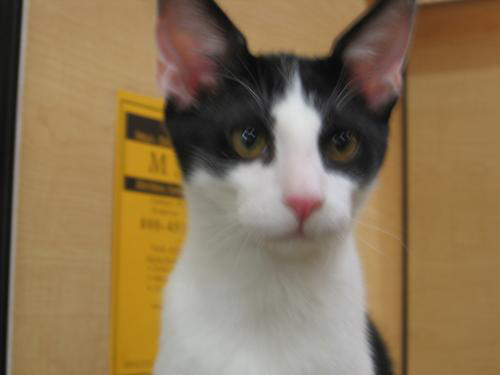

In [14]:
from PIL import Image

path = 'data\cats\987.jpg'
image = Image.open(path)
image

O ruído é adicionado a tensores PyTorch. Primeiro, definiremos transformações de imagem que nos permitam ir de uma imagem PIL para um tensor PyTorch (sobre o qual podemos adicionar o ruído) e vice-versa.

Essas transformações são bastante simples: primeiro normalizamos as imagens dividindo por 255 (de modo que estejam na faixa $[0,1]$), e depois garantimos que estejam na faixa $[-1, 1]$. Do artigo do DDPM:

> Assumimos que os dados da imagem consistem em inteiros em $\{0, 1, ... , 255\}$ escalados linearmente para $[-1, 1]$. Isso garante que o processo reverso da rede neural opere em entradas consistentemente escaladas, começando do priore normal padrão $p(\mathbf{x}_T )$.


Também definimos a transformação inversa, que recebe um tensor PyTorch contendo valores em $[-1, 1]$ e os transforma de volta em uma imagem PIL.


In [15]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np
image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
    
])

x_start = transform(image).unsqueeze(0)
x_start.shape


reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), 
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

Agora podemos definir o processo de difusão direta conforme no artigo:


In [16]:

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):

  x_noisy = q_sample(x_start, t=t)


  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

Vamos testar na foto do gato, num dado t:


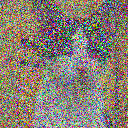

In [17]:

t = torch.tensor([150])

get_noisy_image(x_start, t)

Para uma melhor ilustração, vamos vé-lo passo a passo: 


In [18]:


torch.manual_seed(0)

# fonte: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

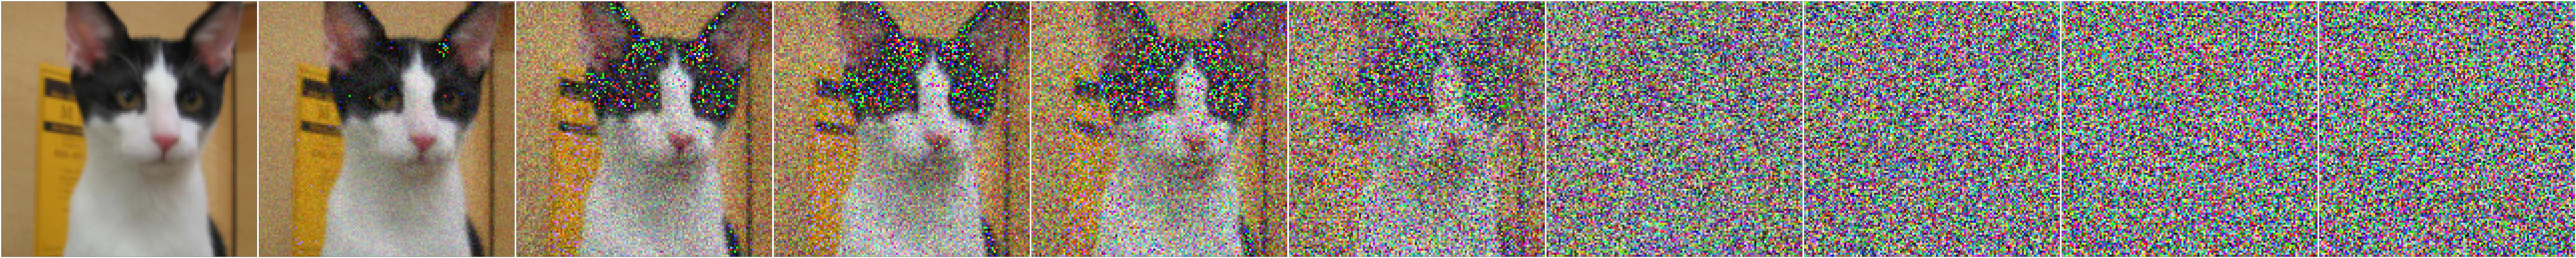

In [19]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 20, 60,80,100, 150,250,350,500,999]])

In [20]:
# Definimos a função de perda dada o modelo
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## Define o Dataset e o DataLoader


Para treinar o modelo vamos precisar de dados, uma forma é fazer o download de algum dataset de [Kaggle](https://kaggle.com) por exemplo, porém uma forma mais fácil e rápida seria usar os datasets disponiveis em [Hugginface](https://huggingface.co/datasets), e é o que vamos utilizar.

Cada imagem é redimensionada para o mesmo tamanho. Interessante notar é que as imagens também são espelhadas horizontalmente aleatoriamente. Do artigo:

> Usamos inversões horizontais aleatórias durante o treinamento para o CIFAR10; tentamos treinar com e sem inversões, e descobrimos que as inversões melhoraram ligeiramente a qualidade da amostra.

O dataset por padrão é o fashion_mnist, este leva em torno de minutos com 10 epocas numa máquina laptop com ryzen 5600H e RTX3050, pois este é o menor, que ainda atinge resultados bons e exige pouco poder de processamento.


In [21]:
from datasets import load_dataset
# Conjunto de dados de plantas, contendo imagens de várias plantas para tarefas de classificação.
# Este conjunto de dados contém múltiplas divisões, incluindo conjuntos de treino, validação e teste.
#dataset = load_dataset("sampath017/plants")

# Conjunto de dados CelebA com atributos para cada imagem, comumente usado para reconhecimento de atributos faciais.
# O conjunto de dados inclui 202.599 imagens com divisões de treino, validação e teste.
#dataset = load_dataset("tpremoli/CelebA-attrs")

# Conjunto de dados MNIST de dígitos manuscritos, usado para tarefas de classificação de dígitos.
# Este conjunto de dados inclui 60.000 imagens de treino e 10.000 imagens de teste.
#dataset = load_dataset("mnist")

# Conjunto de dados Fashion MNIST com imagens de itens de moda, usado para classificação de imagens.
# Este conjunto de dados contém 60.000 imagens de treino e 10.000 imagens de teste.
dataset = load_dataset("fashion_mnist")

# Conjunto de dados CIFAR-10, consistindo em 60.000 imagens coloridas 32x32 em 10 classes, com 6.000 imagens por classe.
# Este conjunto de dados é dividido em 50.000 imagens de treino e 10.000 imagens de teste.
#dataset = load_dataset("cifar10")

# Conjunto de dados de Classificação de Cenas Internas com imagens de várias cenas internas.
# A versão mini contém um subconjunto menor para experimentos rápidos, com divisões de treino e teste.
#dataset = load_dataset("keremberke/indoor-scene-classification","mini")

# Conjunto de dados QuickDraw com pequenos desenhos de vários objetos, usado para tarefas de reconhecimento de imagens.
# O conjunto de dados contém múltiplas classes com divisões de treino e teste.
#dataset = load_dataset("Xenova/quickdraw-small")

# Conjunto de dados QuickDraw, uma versão maior com dados abrangentes de desenhos.
# Inclui divisões de treino e teste para várias classes de objetos.
#dataset = load_dataset("quickdraw","preprocessed_bitmaps")

# Conjunto de dados Milly Images com várias imagens, frequentemente usado para tarefas personalizadas de classificação de imagens.
# A estrutura do conjunto de dados inclui divisões de treino, validação e teste.
#dataset = load_dataset("spongus/milly-images")

# Conjunto de dados de Imagens de Arroz com imagens de diferentes variedades de grãos de arroz, usado para classificação.
# Este conjunto de dados inclui imagens categorizadas em divisões de treino e teste.
#dataset = load_dataset("miladfa7/Rice-Image-Dataset")

# Conjunto de dados SVHN (Números de Casa em Visão de Rua) contendo imagens de dígitos recortados para tarefas de reconhecimento de dígitos.
# O conjunto de dados inclui divisões de treino, teste e extra com dados adicionais rotulados.
#dataset = load_dataset("svhn",'cropped_digits')

# Conjunto de dados Curated Gold Standard de Hoyal Cuthill, usado para pesquisa em imageômica.
# O conjunto de dados inclui imagens cuidadosamente selecionadas com divisões de treino e teste.
#dataset = load_dataset("imageomics/Curated_GoldStandard_Hoyal_Cuthill")

# Conjunto de dados de Gatos e Cachorros com imagens de gatos e cachorros, usado para tarefas de classificação binária.
# O conjunto de dados contém divisões de treino, validação e teste.
#dataset = load_dataset("Bingsu/Cat_and_Dog")

# Conjunto de dados A-MNIST, uma variação do conjunto de dados MNIST com diferentes propriedades ou aumentações.
# O conjunto de dados inclui divisões de treino e teste.
#dataset = load_dataset("gorar/A-MNIST")


print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [22]:

image_size = 28
channels = 1 # Cinza, mudar para 3 quando trabalhar com imagens no rgb
batch_size = 128 # Tamanho das divisoes do dataset, significa o numero de
#imagens que treinam o modelo por ciclo, quando maior mais memoria da fpu ou memeoria ram (se usar cpu) vai ser preciso

In [23]:
# Mudar a label caso necessario
""" dataset = dataset.rename_column("img","image") """

' dataset = dataset.rename_column("img","image") '

In [24]:
# Para multi-class-image datasets podemos selecionar a classe que quisermos,
# ou usá-las todas
""" 
# CIFAR-10 classes
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
bingsu_classes = [
    "dog","cat"
]

# Filtra o dataset para obter só as linhas onde a 'label' é "cat" por exemplo
def filter_cat(example):
    return bingsu_classes[example['labels']] == "cat"

dataset = dataset.filter(filter_cat)

print(dataset)
 """


' \n# CIFAR-10 classes\ncifar10_classes = [\n    "airplane", "automobile", "bird", "cat", "deer",\n    "dog", "frog", "horse", "ship", "truck"\n]\nbingsu_classes = [\n    "dog","cat"\n]\n\n# Filtra o dataset para obter só as linhas onde a \'label\' é "cat" por exemplo\ndef filter_cat(example):\n    return bingsu_classes[example[\'labels\']] == "cat"\n\ndataset = dataset.filter(filter_cat)\n\nprint(dataset)\n '

In [25]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define transfomrções
# algumas das transfomrções só são precisas se estiver:
# 1 a trabalhar com imagens de tamanhos irregulares do dataset
# e/ou
# 2 a trabalhar com imagens com todas as cores (rgb)
transform = Compose([ 
            #transforms.Resize((image_size,image_size)), # 1
            #Resize(image_size), # 1
            #CenterCrop(image_size), # 1
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1),
            #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 2
           
])

# função para as transformações 
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.select_columns("image").with_transform(transforms)

# criamos o dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)


In [26]:
print(transformed_dataset["train"])

Dataset({
    features: ['image'],
    num_rows: 60000
})


In [27]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


## Amostragem

Como vamos amostrar do modelo durante o treinamento, definimos uma função para isso. A amostragem é resumida no artigo como Algoritmo 2:


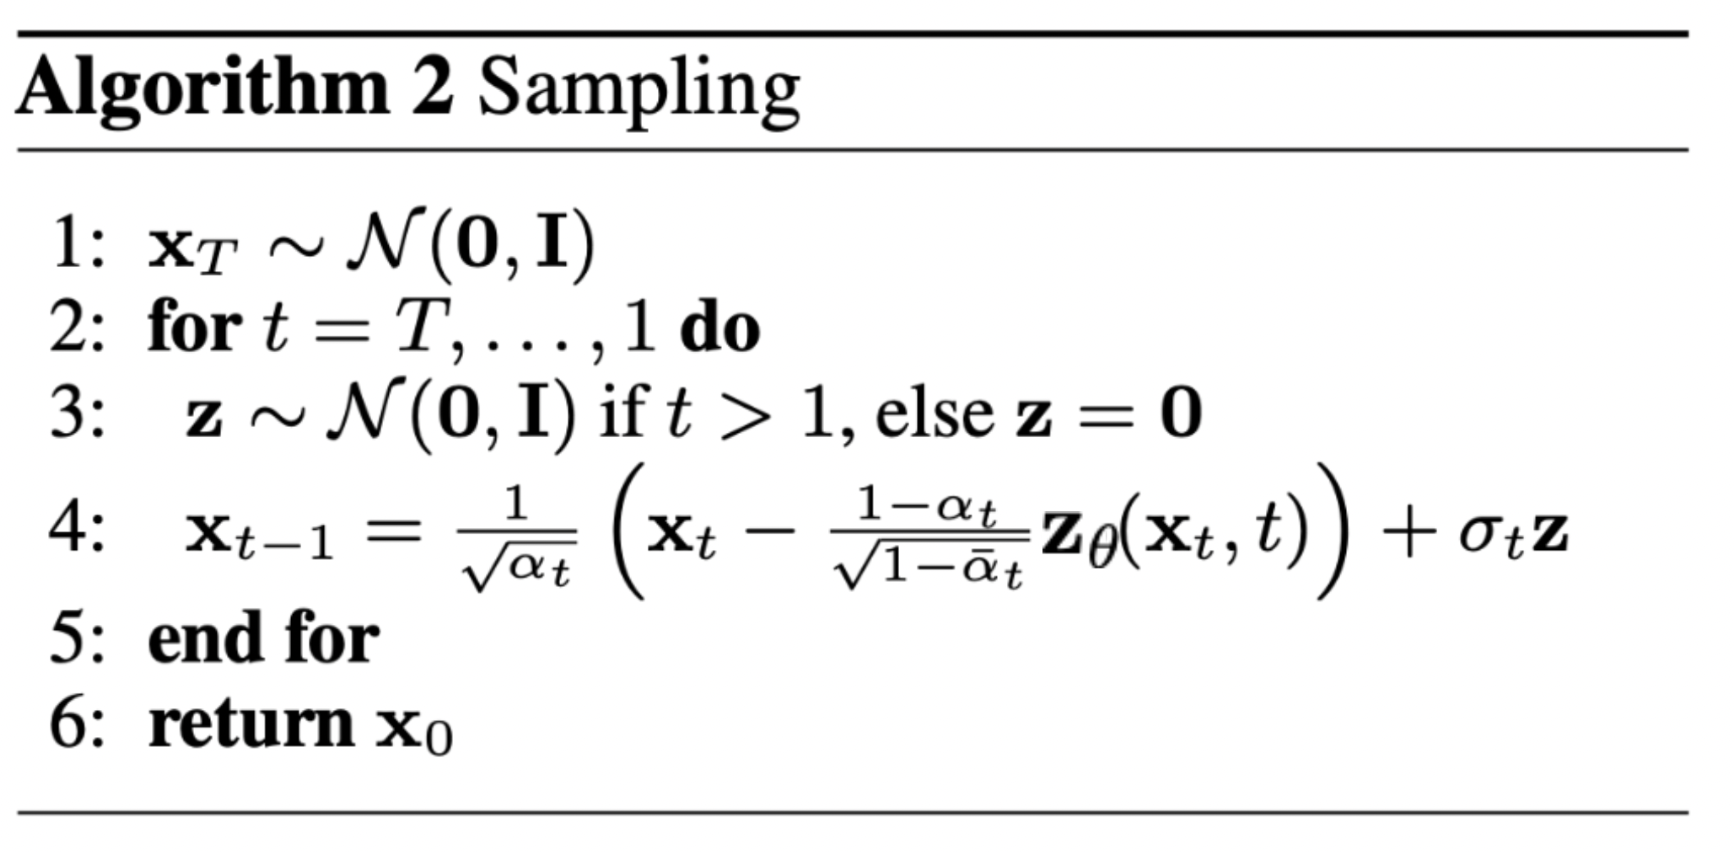



Gerar novas imagens a partir de um modelo de difusão acontece ao reverter o processo de difusão: 
começamos em $T$, onde amostramos ruído puro de uma distribuição gaussiana, e então usamos nossa rede neural para gradualmente "desnoisá-lo" (com a probabilidade condicional que ela aprendeu), até chegarmos ao passo de tempo $t = 0$. 
Como mostrado acima, podemos derivar uma imagem um pouco menos "desnoisada" $\mathbf{x}_{t-1 }$ ao inserir a reparametrização da média.

Idealmente, acabamos com uma imagem que parece ter vindo da distribuição de dados reais.

O código abaixo implementa isso.

Nota: O código é uma versão simplificada da [implementação original, mais complexa](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


In [28]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# algoritmo 2
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # começa de puro ruido para cada exemplo no pacote
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

## Treinar o modelo

Em seguida, treinamos o modelo da maneira regular do PyTorch. Também definimos alguma lógica para guardar periodicamente imagens geradas, com o método sample definido acima.


In [29]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Abaixo, definimos o modelo e o movemos para a GPU. Também definimos um otimizador padrão (Adam).


In [30]:
from torch.optim import Adam

device =  torch.device('cuda') # Mudar para cpu caso não tenha gpu capaz da tarefa

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

Treinar

In [39]:
from torchvision.utils import save_image

epochs = 10
global_step = 0
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")
      loss.backward()
      optimizer.step()

      # salva imagens geradas
      if global_step != 0 and global_step % save_and_sample_every == 0:
        milestone = global_step //save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = torch.tensor(np.array(list(map(lambda n: sample(model,image_size=image_size, batch_size=n, channels=channels), batches))))
        all_images = torch.cat([img for sublist in all_images_list for img in sublist], dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
      global_step +=1
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.10f}')
    print(global_step)

# Avisa quando terminar
notification.notify(
    title='Training Completed',
    message='The model training was successfully completed.',
    app_name='Training Model',
    timeout=10  
)


Epoch [1/10], Loss: 0.0203639232
469
Epoch [2/10], Loss: 0.0181039069
938


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.0139767826
1407
Epoch [4/10], Loss: 0.0238411892
1876


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0224390384
2345
Epoch [6/10], Loss: 0.0223128572
2814


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0179366190
3283
Epoch [8/10], Loss: 0.0166179202
3752


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0158742815
4221
Epoch [10/10], Loss: 0.0205840599
4690


## Amostragem 

Para amostrar do modelo, podemos usar apenas nossa função de amostragem já definida acima:


In [32]:
# sample images
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

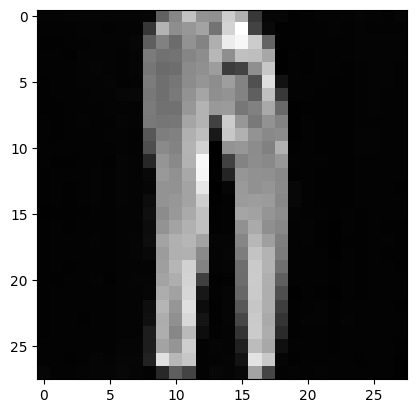

In [37]:
# vamos olhar para uma das imagens aleatóriamente
import random
random_index =random.randint(0, batch_size-1)
random_index = 12
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels),cmap="gray")

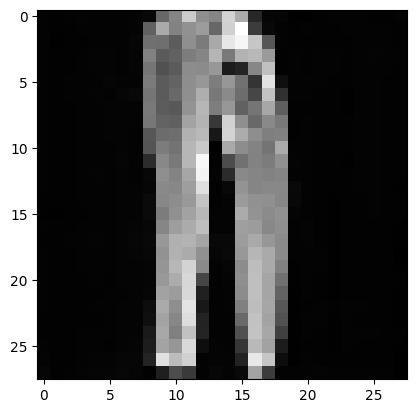

Podemos ver que gerou uma calça relativamente bem estruturada.

## Conclusão

O modelo de difusão que implementamos é capaz de gerar imagens relativamente bem definidas, considerando as limitações inerentes ao dataset e aos recursos de hardware disponíveis. Utilizamos um conjunto de dados com resolução de apenas 28x28 pixels, o que inevitavelmente limita a qualidade e o nível de detalhe das imagens geradas. Além disso, o treinamento foi realizado ao longo de poucas épocas. Embora isso tenha resultado em um tempo de treino mais curto e menor exigência de memória da placa gráfica, também significa que o modelo teve menos oportunidades de aprender e ajustar seus parâmetros para produzir resultados mais refinados.

O principal desafio enfrentado foi a restrição de hardware, que impediu a utilização de configurações mais avançadas e tempos de treinamento mais longos. Em condições ideais, com acesso a um hardware mais potente e um conjunto de dados de alta resolução, poderíamos esperar melhorias significativas na qualidade das imagens geradas pelo modelo de difusão. O aumento do número de épocas de treinamento também permitiria ao modelo refinar suas capacidades de geração de imagens, resultando em uma qualidade visual superior.

Por outro lado, é importante destacar que o uso de uma resolução baixa e poucas épocas de treinamento teve seus benefícios. Esses fatores contribuíram para uma redução significativa no tempo de processamento e no consumo de memória, tornando o modelo mais acessível e eficiente em termos de recursos computacionais. Isso é particularmente relevante em contextos onde o hardware disponível é limitado ou quando há necessidade de treinamentos rápidos.

A partir desta experiência, podemos concluir que há um equilíbrio delicado entre a qualidade das imagens geradas e os recursos de hardware disponíveis. Modelos de difusão têm um grande potencial para gerar imagens de alta qualidade, mas suas exigências de processamento podem ser significativas. Portanto, para futuras implementações, seria ideal considerar um modelo pre treinado como o [Stable Diffusion Model] que é um modelo open source resultante da colaboração de [Stability AI](https://stability.ai/) com [Runway](https://runwayml.com/).

Em resumo, embora o modelo desenvolvido neste trabalho tenha produzido resultados modestos devido às limitações do dataset e do hardware, ele demonstrou o potencial da técnica de difusão. Com melhorias nas condições de treinamento e nos recursos disponíveis, poderemos explorar ainda mais as capacidades desse modelo para aplicações mais exigentes e sofisticadas.


Também podemos criar um gif do processo de desnoisamento:






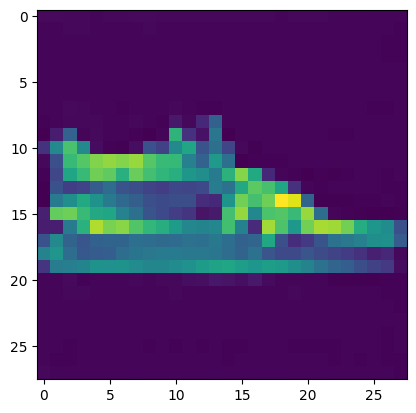

In [38]:
import matplotlib.animation as animation
from IPython.display import display, HTML

random_index = 8

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=1000)

# Salva a animação como um arquivo GIF
ani.save('animation.gif', writer='pillow')

# Exibe a animação no notebook
display(HTML(ani.to_html5_video()))  

## Referências:

Ho, J., Jain, A., & Abbeel, P. (2020). "Denoising Diffusion Probabilistic Models." arXiv preprint arXiv:2006.11239. https://arxiv.org/pdf/2006.11239.

Ho, J. (n.d.). "Diffusion Models." GitHub Repository. https://github.com/hojonathanho/diffusion?tab=readme-ov-file.

Song, Y. (2021, October 17). "Generative Modeling by Estimating Gradients of the Data Distribution." Yang Song's Blog. https://yang-song.net/blog/2021/score/.

Math Stack Exchange. (2016, October 26). "Gaussian Distribution is Isotropic." Math Stack Exchange. https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic.

Kingma, D. P., & Welling, M. (2013). "Auto-Encoding Variational Bayes." arXiv preprint arXiv:1312.6114. https://arxiv.org/pdf/1312.6114.

Weng, L. (2021, July 11). "What are Diffusion Models?" Lil'Log. https://lilianweng.github.io/posts/2021-07-11-diffusion-models/.

Wikipedia. (2024, May 26). "Autoencoder." Wikipedia. https://en.wikipedia.org/wiki/Autoencoder.

Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). "Generative Adversarial Nets." arXiv preprint arXiv:1406.2661. https://arxiv.org/pdf/1505.04597.

Dhariwal, P., & Nichol, A. (2021). "Diffusion Models Beat GANs on Image Synthesis." arXiv preprint arXiv:2105.05233. https://arxiv.org/pdf/2201.03545.

Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Radford, A., & Chen, X. (2016). "Improved Techniques for Training GANs." arXiv preprint arXiv:1606.03498. https://arxiv.org/pdf/1512.03385.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). "Attention is All You Need." arXiv preprint arXiv:1706.03762. https://arxiv.org/pdf/1706.03762.

PyTorch. (n.d.). "Transforms Tutorial." PyTorch. https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py.

Ho, J. (n.d.). "Diffusion Utils." GitHub Repository. https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py.
